<a href="https://colab.research.google.com/github/TMKarunarathne/FYP/blob/main/full_cluster_prediction_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import datetime as dt
import scipy.io
import os
import math
from sklearn.metrics import mean_squared_error,mean_absolute_error 
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive
Mounted at /content/gdrive


In [ ]:
rand_state =1000
mat_file = '/content/gdrive/MyDrive/Data_Set/FV_10000x8928_01.mat'
mat = scipy.io.loadmat(mat_file)

df1= pd.DataFrame(mat['df'])
df1 = df1.drop(df1.columns[[0]], axis=1)
df1=df1.iloc[:,1:]
col = [i for i in range(1,10001)]
df1 = df1.set_axis(col, axis=1)
dates_x = pd.to_datetime(pd.DataFrame(mat['df'])[1], unit="s")
df1.set_index(dates_x,inplace=True)
df1.index.freq = '10min'

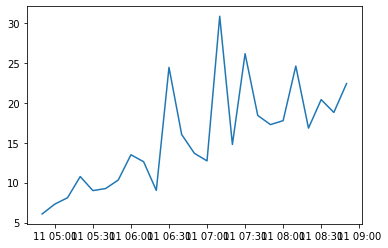

In [ ]:
plt.plot(df1.iloc[144*10+35:144*10+60,2278])

In [ ]:
# 2278    5044
df_2279=df1.iloc[144*60:144*61,2278]
df_2279.describe()

count    144.000000
mean       6.661967
std        2.341621
min        1.955225
25%        4.443784
50%        7.042401
75%        8.332389
max       12.201546
Name: 2279, dtype: float64

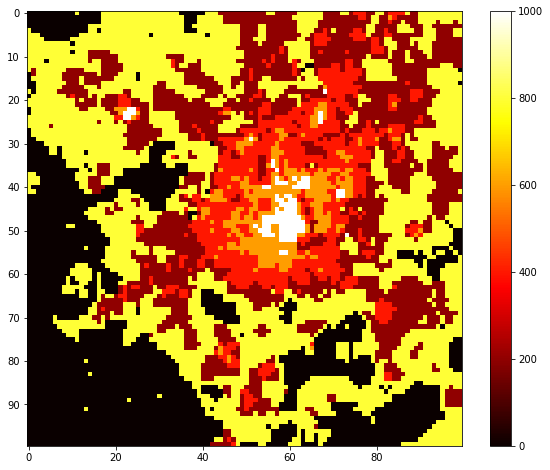

In [ ]:
path = '/content/gdrive/MyDrive/Data_Set/clusters_GMM.csv'
frame = pd.read_csv(path)
frame = frame.drop(frame.columns[[0]], axis=1)
index = [i+1 for i in range(10000)]
frame = frame.set_index(pd.Index(index))

# Make a 100x100 grid...
nrows, ncols = 100,100
image = np.zeros(nrows*ncols,dtype = float)

for i in range(100):
    for j in range(100):
      if int(frame.loc[10000-(100*(i+1))+j+1]['cluster']) == 0:
        image[(100*i)+j]=0
      elif int(frame.loc[10000-(100*(i+1))+j+1]['cluster']) == 1:
        image[(100*i)+j]=200
      elif int(frame.loc[10000-(100*(i+1))+j+1]['cluster']) == 2:
        image[(100*i)+j]=400
      elif int(frame.loc[10000-(100*(i+1))+j+1]['cluster']) == 3:
        image[(100*i)+j]=600
      elif int(frame.loc[10000-(100*(i+1))+j+1]['cluster']) == 4:
        image[(100*i)+j]=800
      elif int(frame.loc[10000-(100*(i+1))+j+1]['cluster']) == 5:
        image[(100*i)+j]=1000

image = image.reshape((nrows, ncols))

fig, ax = plt.subplots(figsize=(10,8))
c = ax.matshow(image,interpolation ='nearest',cmap='hot')
fig.colorbar(c, ax = ax)
ax.set_xticks(np.arange(0,99,20))
ax.xaxis.set_ticks_position("bottom")
ax.set_yticks(np.arange(0,99,10))

In [ ]:
frame.loc[5045]['cluster']

2

In [ ]:
cluster_2=np.array(frame[frame['cluster']==2]['cell_NO'])
cluster_2=np.array(cluster_2)
cluster_2.shape

(1090,)

In [ ]:
slctd_cells_cl_2 = cluster_2[::5]
slctd_cells_cl_2

array([  48, 1051, 1250, 1654, 1754, 1848, 1946, 2048, 2247, 2349, 2982,
       3083, 3183, 3283, 3423, 3532, 3558, 3626, 3650, 3659, 3685, 3751,
       3757, 3764, 3775, 3848, 3853, 3858, 3864, 3872, 3948, 3953, 3958,
       3963, 3969, 4038, 4052, 4058, 4066, 4072, 4140, 4147, 4152, 4164,
       4169, 4240, 4247, 4252, 4265, 4270, 4342, 4348, 4353, 4371, 4444,
       4449, 4467, 4472, 4543, 4568, 4641, 4646, 4671, 4743, 4748, 4770,
       4837, 4844, 4852, 4870, 4891, 4941, 4947, 4973, 5026, 5041, 5049,
       5090, 5142, 5172, 5243, 5250, 5272, 5344, 5351, 5371, 5437, 5446,
       5455, 5470, 5541, 5546, 5551, 5564, 5572, 5647, 5656, 5673, 5746,
       5764, 5846, 5852, 5877, 5949, 6044, 6049, 6056, 6144, 6152, 6170,
       6178, 6248, 6253, 6272, 6279, 6350, 6359, 6369, 6445, 6450, 6461,
       6469, 6474, 6547, 6552, 6562, 6567, 6572, 6578, 6645, 6652, 6661,
       6666, 6672, 6686, 6751, 6756, 6764, 6776, 6787, 6853, 6860, 6869,
       6874, 6885, 6953, 6959, 6967, 6972, 6979, 70

In [ ]:
b = pd.DataFrame(df1[6:])
train=[]
test=[]
timesteps = 7
tr_len = 2304 
for cells in slctd_cells_cl_2:
  df4 = pd.DataFrame(b[cells])
  train.append(df4[cells][:tr_len].values) #8weeks
  test.append(df4[cells][tr_len-timesteps+2:tr_len+145].values) #1day

In [ ]:
train=np.array(train)
test=np.array(test)

In [ ]:
no_cells = train.shape[0]
no_cells

218

In [ ]:
all_x_train = []
all_y_train = []

train_data = train
test_data = test

for i in range(no_cells):
  train_data = train[i]
  train_data = train_data.reshape(len(train_data),1)
  test_data = test[i]
  test_data = test_data.reshape(len(test_data),1)

  train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
  x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,timesteps-1:]

  for j in range(x_train.shape[0]):
    all_x_train.append(x_train[j].tolist())
    all_y_train.append(y_train[j].tolist())


In [ ]:
all_x_train = np.array(all_x_train)
all_y_train = np.array(all_y_train)

In [ ]:
x=all_x_train.reshape(all_x_train.shape[0]*all_x_train.shape[1],1)
y=all_y_train.reshape(all_y_train.shape[0]*all_y_train.shape[1],1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
y_scaled = scaler.transform(y)

x_scaled_train = x_scaled.reshape(all_x_train.shape[0],all_x_train.shape[1])
y_scaled_train = y_scaled.reshape(all_y_train.shape[0],all_y_train.shape[1])

In [ ]:
print(x_scaled_train.shape)
print(y_scaled_train.shape)

(500964, 6)
(500964, 1)


In [ ]:
x_scaled_train= np.reshape(x_scaled_train,(x_scaled_train.shape[0], 1, x_scaled_train.shape[1]))
y_scaled_train= np.reshape(y_scaled_train,(y_scaled_train.shape[0], 1, y_scaled_train.shape[1]))

In [ ]:
HL1=4320
HL2=144
HL3=1080
Dropout_rate = 0.2
GaussianNoise_STD = 0.29
HL4 = 144
LSTM1=36
LSTM2=144
batch_size =144
epsilon = 0.001


# #initializing the ann
# ann = tf.keras.models.Sequential()

# ann.add(tf.keras.layers.Dense(units=4320, activation='tanh'))
# #######
# ann.add(tf.keras.layers.GRU(units=1000,return_sequences=True,go_backwards=True,unroll=True))
# ann.add(tf.keras.layers.Dropout(Dropout_rate,input_shape=(batch_size,1,x_scaled_train.shape[2])))


# ann.add(tf.keras.layers.GRU(units=300))
# ann.add(tf.keras.layers.Dropout(Dropout_rate))


# #adding output layer
# ann.add(tf.keras.layers.Dense(units=1))
######################################################

#initializing the ann
ann = tf.keras.models.Sequential()

#ann.add(tf.keras.layers.Dense(units=4320, activation='tanh'))
ann.add(tf.keras.layers.LSTM(units=1000,return_sequences=True,go_backwards=True,unroll=True))
#######
ann.add(tf.keras.layers.LSTM(units=1000,return_sequences=True,go_backwards=True,unroll=True))
ann.add(tf.keras.layers.Dropout(Dropout_rate,input_shape=(batch_size,1,x_scaled_train.shape[2])))
#ann.add(tf.keras.layers.Dense(units=144, activation='swish'))
ann.add(tf.keras.layers.LSTM(units=300,return_sequences=True,go_backwards=True,unroll=True))
ann.add(tf.keras.layers.Dropout(Dropout_rate,input_shape=(batch_size,1,x_scaled_train.shape[2])))
ann.add(tf.keras.layers.LSTM(units=300))
ann.add(tf.keras.layers.Dropout(Dropout_rate))

#adding output layer
ann.add(tf.keras.layers.Dense(units=1))


#########################################################



# #initializing the ann
# ann = tf.keras.models.Sequential()

# ann.add(tf.keras.layers.Dense(units=4320, activation='tanh'))

# ann.add(tf.keras.layers.LSTM(units=432,return_sequences=True,go_backwards=True,unroll=True))

# #adding Batch normalization layer with dropouts
# ann.add(tf.keras.layers.Dense(units=4032, activation='swish'))
# ann.add(tf.keras.layers.Dense(units=144, activation='swish'))
# ann.add(tf.keras.layers.Dropout(Dropout_rate,input_shape=(batch_size,1,x_scaled_train.shape[2])))

# #adding hidden LSTM layers
# ann.add(tf.keras.layers.LSTM(units=144,input_shape=(batch_size,1,x_scaled_train.shape[2]),return_sequences=True,go_backwards=True,unroll=True))
# #ann.add(tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=0.005))

# #adding dense layer
# ann.add(tf.keras.layers.Dense(units=1080, activation='relu'))
# tf.keras.layers.LayerNormalization(epsilon=epsilon)

# #ann.add(tf.keras.layers.RepeatVector(2))

# #adding hidden LSTM layers
# ann.add(tf.keras.layers.LSTM(units=144,input_shape=(batch_size,1,x_scaled_train.shape[2]),return_sequences=True))
# ann.add(tf.keras.layers.GaussianNoise(GaussianNoise_STD,seed=1000))


# #adding output layer
# ann.add(tf.keras.layers.Dense(units=1))

In [ ]:
def triplet_loss(y_true, y_pred, alpha=1e-2):
  return max(tf.reduce_sum((y_pred[0]-y_true)**2 - (y_pred[0]-y_pred[1])**2) + alpha, 0)

ann.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())

In [ ]:
history=ann.fit(x_scaled_train, y_scaled_train, batch_size = batch_size, epochs = 3, validation_split=0.25, verbose=2)

Epoch 1/3
2610/2610 - 24s - loss: 4.0763e-04 - val_loss: 1.6751e-04 - 24s/epoch - 9ms/step
Epoch 2/3
2610/2610 - 21s - loss: 3.4209e-04 - val_loss: 1.6950e-04 - 21s/epoch - 8ms/step
Epoch 3/3
2610/2610 - 20s - loss: 3.4107e-04 - val_loss: 1.7636e-04 - 20s/epoch - 8ms/step


In [ ]:
ann.summary()

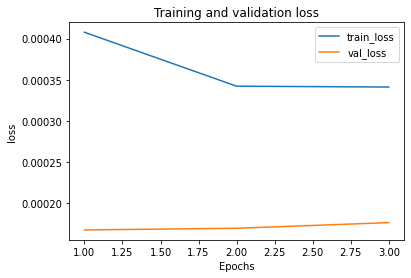

In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history, 'loss')

In [ ]:
#saving model
#ann.save('/content/gdrive/MyDrive/Data_Set/cluster2_100%data_version2_.h5')

In [ ]:
#from tensorflow.keras.models import load_model
#ann = load_model('/content/gdrive/MyDrive/Data_Set/cluster2_LSTM_Nadu_version2_.h5')

# **prediction**

## **step1**

In [ ]:
b[5045]

1
2013-11-01 00:00:00    120.199779
2013-11-01 00:10:00    120.992325
2013-11-01 00:20:00    109.403864
2013-11-01 00:30:00    106.119279
2013-11-01 00:40:00    119.711693
                          ...    
2014-01-01 22:10:00     46.877864
2014-01-01 22:20:00     45.001280
2014-01-01 22:30:00     39.873746
2014-01-01 22:40:00     41.689660
2014-01-01 22:50:00     44.822092
Freq: 10T, Name: 5045, Length: 8922, dtype: float64

In [ ]:
cell =5045
#cell= 5275
df4 = pd.DataFrame(b[cell])
test = df4[cell][tr_len-timesteps+1:tr_len+720].values #1day
test = test.reshape(len(test),1)
print('Test data shape: ', test.shape)

Test data shape:  (726, 1)


In [ ]:
test = scaler.transform(test)

In [ ]:
test_data = test
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,timesteps-1:]
print(x_test.shape, y_test.shape)

(720, 6) (720, 1)


In [ ]:
x_test = np.reshape(x_test,(x_test.shape[0], 1, x_test.shape[1]))
y_test_pred = ann.predict(x_test)
y_test_pred = y_test_pred.reshape(-1,1) 

y_test_act = scaler.inverse_transform(y_test)
y_test_pred_1 = scaler.inverse_transform(y_test_pred)
y_test_final = y_test_pred_1[:]

In [ ]:
test_timestamps = df4[2304:2304+720].index

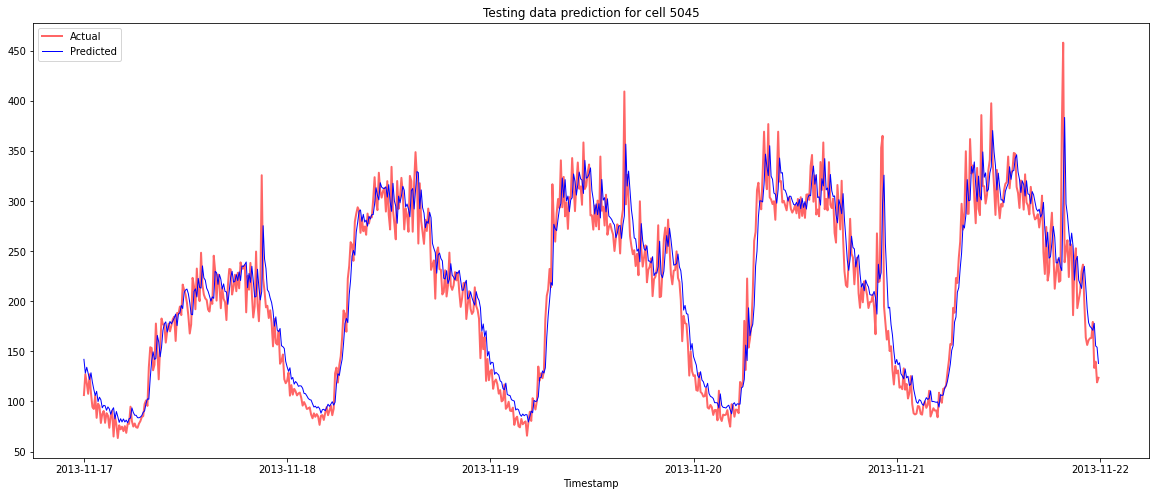

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(test_timestamps[:], y_test_act[:], color = 'red', linewidth=2.0, alpha = 0.6)
#plt.plot(test_timestamps[:], y_test_pred[:], color = 'green', linewidth=1)
plt.plot(test_timestamps[:], y_test_final[:], color = 'blue', linewidth=1)
#plt.plot(test_timestamps, np.abs(y_test_final - y_test_act))
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Testing data prediction for cell "+str(cell))
plt.show()

In [ ]:
import sklearn
from sklearn.metrics import mean_absolute_percentage_error

def mspe(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.square((actual - pred) / actual)) 

In [ ]:

#e=mspe(y_test_final[:],y_test_act[:])
#print('MSPE for testing data: ', e*100, '%')

In [ ]:
square_act = np.mean(np.square(y_test_act))
square_error = np.mean(np.square((y_test_act-y_test_final)/y_test_act))
root_square_error = square_error**0.5
mspe=square_error*100
mean_act = np.mean(y_test_act)
rmspe = (root_square_error/ mean_act)*100
print('MAPE for testing data: ', mean_absolute_percentage_error(y_test_act[:],y_test_final[:])*100, '%')
print('mspe'+' = '+str(mspe))
print('rmspe'+' = '+str(root_square_error*100))

MAPE for testing data:  10.239663543089677 %
mspe = 1.7950615796190177
rmspe = 13.397990818100366


In [ ]:
import sklearn
from sklearn.metrics import mean_absolute_percentage_error

def max_min_error(y_test,y_test_pred):
  n=len(y_test)
  max_positive_error=0      #prediction is larger than actual
  max_negative_error=0      #prediction is smaller than actual
  for i in range(n):
    #error=(-y_test[i][0]+y_test_pred[i])/y_test[i][0]
    error=(-y_test[i][0]+y_test_pred[i][0])/y_test[i][0]
    if error > 0 :
      if error > max_positive_error:
        max_positive_error=error
    if error < 0:
      error=abs(error)
      if error > max_negative_error :
        max_negative_error=error
  
  return max_positive_error*100,max_negative_error*100

MAPE=[]
mean_error=[]
error_std=[]
max_positive_error_perc=[]
max_negative_error_perc=[]
tr_ten=2304

for z in range(len(cluster_2)):
  v = cluster_2[z]

  test_period =144*5
  df4 = pd.DataFrame(b[v])
  test = df4[v][tr_len-timesteps+1:tr_len+test_period].values #1day
  test = test.reshape(len(test),1)
  test = scaler.transform(test)
  
  test_data = test
  test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
  x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,timesteps-1:]

  x_test = np.reshape(x_test,(x_test.shape[0], 1, x_test.shape[1]))
  y_test_pred = ann.predict(x_test)
  y_test_pred = y_test_pred.reshape(-1,1) 
  
  y_test_act = scaler.inverse_transform(y_test) 
  y_test_pred_1 = scaler.inverse_transform(y_test_pred) 
  y_test_final = y_test_pred_1[:]
  #u=np.array([y_test_pred_1[i][0] for i in range(test_period)]) 
  #y_test_final=u + np.random.poisson(10,test_period)
  
  temp_MAPE = mean_absolute_percentage_error(y_test_act[:],y_test_final[:])*100
  MAPE.append(temp_MAPE)

  error_1=[]
  for i in range(test_period):
    #temp=y_test_final[i]-y_test_act[i][0]
    temp=(y_test_final[i][0]-y_test_act[i][0])**2
    error_1.append(temp)
  error_1 = np.array(error_1)
  mean = np.mean(error_1)
  std = np.std (error_1)
  mean_error.append(mean)
  error_std.append(std)
  
  x,y=max_min_error(y_test_act[:],y_test_final[:])
  max_positive_error_perc.append(x)
  max_negative_error_perc.append(y)

MAPE=np.array(MAPE)
mean_error=np.array(mean_error)
error_std=np.array(error_std)
max_positive_error_perc=np.array(max_positive_error_perc)
max_negative_error_perc=np.array(max_negative_error_perc)

In [ ]:
pred_results_cluster_2 = pd.DataFrame(list(zip(cluster_2,MAPE,mean_error,error_std,max_positive_error_perc,max_negative_error_perc)), index=[i for i in range(len(cluster_2))], columns =['cell_NO', 'MAPE','mean error','std of error','max positive error percentage','max negative error percentage'] )
#pred_results_cluster_2

In [ ]:
#pred_results_cluster_2[pred_results_cluster_2['MAPE']>100]['cell_NO']

In [ ]:
#pred_results_cluster_2.describe()

In [ ]:
pred_results_cluster_2_1= pred_results_cluster_2.drop(labels=[779,804,921,922,923], axis=0)
pred_results_cluster_2_1.describe()

,cell_NO,MAPE,mean error,std of error,max positive error percentage,max negative error percentage
count,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000
mean,5928.903226,15.078377,1095.021300,3990.179309,103.814540,68.112193
std,1860.671706,10.394956,985.371709,5316.909433,82.330956,103.652095
min,48.000000,5.053081,52.722001,38.522165,10.398550,27.431779
25%,4445.000000,10.146813,422.990985,1155.260540,61.160151,48.460205
50%,6155.000000,11.893600,796.394944,2373.271130,83.145536,57.390678
75%,7265.000000,15.543143,1470.164402,4723.704127,119.520785,68.519933
max,9987.000000,166.293390,7885.951102,65320.157508,1374.820232,3113.252172


In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100
    #return np.mean(np.abs(actual - pred)) / np.mean(actual) * 100

mape(y_test_final[:],y_test_act[:])

13.15852775252874